# **Chargement de données et biblios** 

On va importer les bibliothèques nécessaires pour le projet de système de recommandation. Les bibliothèques utilisées comprennent Pandas, NumPy, Matplotlib, Surprise, Hyperopt et Scikit-learn. Ensuite, on lit le fichier `normal data.csv` à l'aide de Pandas en ne sélectionnant que les colonnes `userId`, `movieId` et `rating`. Ces colonnes seront utilisées comme variables dans nos dataframes de données pour construire le système de recommandation.

In [3]:
from pandas.core.generic import ColspaceArgType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from surprise import Dataset, Reader, SVD, NMF, SlopeOne, CoClustering, SVDpp,KNNBaseline
from surprise.prediction_algorithms import SVD, NMF, KNNBasic
from surprise.model_selection import cross_validate, train_test_split, LeaveOneOut
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import pickle

data = pd.read_csv("../data/normal data.csv",usecols=['userId','movieId','rating'])
movies = pd.read_csv("../data/movies.csv",usecols=['title','movieId'])
data = pd.merge(data,movies,on='movieId')


La fonction `remove_outliers` élimine les valeurs aberrantes d'un dataframe en se basant sur la méthode de l'IQR (interquartile range). Elle calcule l'IQR en utilisant les quartiles Q1 et Q3 de la colonne spécifiée, puis définit des bornes inférieure et supérieure en ajoutant ou en soustrayant 1% de l'IQR. Les valeurs qui se situent en dehors de ces bornes sont filtrées et le dataframe résultant, ne contenant que les données sans valeurs aberrantes, est renvoyé en sortie.

In [ ]:
def remove_outliers(data, column_name):
    # Calculate the IQR
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 0.01 * IQR
    upper_bound = Q3 + 0.01 * IQR

    # Remove outliers
    filtered_data = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]
    
    return filtered_data

# **Analyse exploratoire des données et préparation**

L'appel à `data.head()` affichera les premières lignes du dataframe `data`, qui contient les colonnes `userId`, `movieId`, `rating` et `title`.

In [ ]:
data.head()

,userId,movieId,rating,title
501499,272830,172,3.0,Johnny Mnemonic (1995)
349977,153685,509,3.5,"Piano, The (1993)"
481452,182865,1234,4.0,"Sting, The (1973)"
246488,139100,597,4.0,Pretty Woman (1990)
454581,77792,553,4.0,Tombstone (1993)


Le nombre des occurrences de chaque valeur dans la colonne `rating`.

In [ ]:
data[["rating"]].value_counts()

rating
4.0       169846
5.0       145623
3.0       129438
4.5        47135
3.5        40669
2.0        32306
1.0        17981
2.5        14015
0.5         7429
1.5         5376
dtype: int64

On va calculer le nombre d'occurrences de chaque valeur de `rating` en prenant en compte la normalisation, ce qui permet d'obtenir les proportions de chaque valeur par rapport à l'ensemble des données. 

In [ ]:
rating_counts = data['rating'].value_counts(normalize=True).sort_index()
rating_counts

0.5    0.012182
1.0    0.029486
1.5    0.008816
2.0    0.052976
2.5    0.022982
3.0    0.212257
3.5    0.066690
4.0    0.278519
4.5    0.077294
5.0    0.238797
Name: rating, dtype: float64

On va créer un diagramme circulaire à partir des données de `rating_counts`. Pour visualiser la répartition des différentes valeurs de `rating`. 

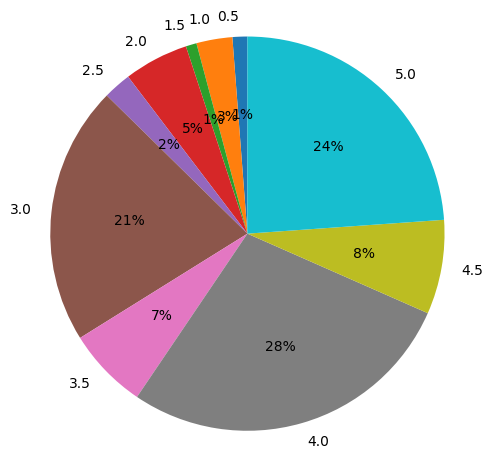

In [ ]:
# Créer une figure avec une taille de (18, 6)
plt.figure(figsize=(10, 4))

# Tracer le diagramme en secteurs
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.0f%%', startangle=90, radius=1.6)

# Afficher le graphique
plt.show()

On va créer un `boxplot` de la colonne `rating`. Pour visualiser la distribution des valeurs et d'identifier les  valeurs extrêmes. 



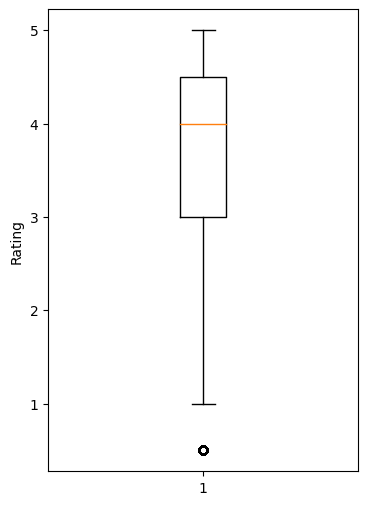

In [ ]:
# Créer une figure avec une taille de (4, 6)
plt.figure(figsize=(4, 6))

# Tracer le boxplot
plt.boxplot(data['rating'])

# Définir le label de l'axe y
plt.ylabel('Rating')

# Afficher le graphique
plt.show()

On va découvrir les 10 films les plus populaires par ordre de popularité décroissante

In [ ]:
data['title'].value_counts()[:10]

Shawshank Redemption, The (1994)             7020
Forrest Gump (1994)                          5946
Pulp Fiction (1994)                          5913
Silence of the Lambs, The (1991)             5501
Star Wars: Episode IV - A New Hope (1977)    4543
Matrix, The (1999)                           4283
Jurassic Park (1993)                         4124
Schindler's List (1993)                      4120
Toy Story (1995)                             3929
Braveheart (1995)                            3901
Name: title, dtype: int64

# **Modelisation**

La variable `data` est mise à jour en appliquant la fonction `remove_outliers` pour éliminer les valeurs aberrantes de la colonne `'rating'`. Le dataframe résultant, ne contenant que les données sans valeurs aberrantes dans la colonne `'rating'`, est assigné à la variable `data`.

In [ ]:
data = remove_outliers(data, 'rating')

La fonction `np.random.seed(42)` permet de fixer la graine (seed) du générateur de nombres aléatoires de NumPy. Cela garantit que les résultats aléatoires générés par NumPy seront les mêmes à chaque exécution du code, ce qui assure la reproductibilité.

Ensuite, la variable `data` est mise à jour en utilisant la méthode `sample` pour échantillonner aléatoirement 20 000 lignes (observations) du dataframe initial. Cela permet de réduire la taille du dataframe à un échantillon de 20 000 lignes, sélectionnées de manière aléatoire à partir des données d'origine.

In [ ]:
np.random.seed(42)

data = data.sample(n=20000)

On va utiliser la bibliothèque `Surprise` pour mettre en œuvre différents types de systèmes de recommandation basés sur le filtrage collaboratif. On va évaluer les performances de chaque type de système, puis on va choisir le bon modéle et on va optimiser ces hyperparamètres.

** **

On va créer un objet `reader` en utilisant la classe `Reader` de la bibliothèque Surprise. Cet objet est configuré avec une échelle de notation allant de `0.5` à `5` pour indiquer la plage de valeurs possibles dans les données de notation.

Ensuite, on va préparer les données dans le format compatible avec la bibliothèque `Surprise`.

In [ ]:
# Create a reader object
reader = Reader(rating_scale=(0.5, 5))

# Load the data into a surprise dataset
data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

#### **Filtrage collaboratif basé sur le modéle**

In [ ]:
# Define the models to evaluate
models = [SVD(), NMF(), KNNBasic(), SVDpp()]

# Evaluate each model using cross-validation
for model in models:
    print(f"Evaluating {model.__class__.__name__}:")
    results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    avg_rmse = round(results['test_rmse'].mean(), 4)
    avg_mae = round(results['test_mae'].mean(), 4)
    print(f"Average RMSE: {avg_rmse}")
    print(f"Average MAE: {avg_mae}")
    print("------------------")

#### **Filtrage collaboratif basé utilisateurs**

In [ ]:
# Define the algorithms
algos = [KNNBasic(sim_options={'user_based': True}), 
         KNNBasic(sim_options={'user_based': True, 'user_mean': 0, 'sim_options': {'name': 'pearson', 'user_based': True, 'user_mean': 0}}), 
         KNNBaseline(sim_options={'user_based': True})]# Compare the algorithms using cross-validation
for algo in algos:
    print(f"Evaluating {algo.__class__.__name__}:")
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    avg_rmse = round(results['test_rmse'].mean(), 4)
    avg_mae = round(results['test_mae'].mean(), 4)
    print(f"Average RMSE: {avg_rmse}")
    print(f"Average MAE: {avg_mae}")
    print("------------------")

#### **Filtrage collaboratif basé utilisateurs sur les films**

In [ ]:
# Define the algorithms
algos = [KNNBasic(sim_options={'user_based': True}), 
         KNNBasic(sim_options={'user_based': True, 'user_mean': 0, 'sim_options': {'name': 'pearson', 'user_based': True, 'user_mean': 0}}), 
         KNNBaseline(sim_options={'user_based': True})]# Compare the algorithms using cross-validation
for algo in algos:
    print(f"Evaluating {algo.__class__.__name__}:")
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    avg_rmse = round(results['test_rmse'].mean(), 4)
    avg_mae = round(results['test_mae'].mean(), 4)
    print(f"Average RMSE: {avg_rmse}")
    print(f"Average MAE: {avg_mae}")
    print("------------------")

Evaluating KNNBasic:
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5437  0.5398  0.5422  0.5416  0.5482  0.5431  0.0028  
MAE (testset)     0.4824  0.4790  0.4803  0.4808  0.4878  0.4820  0.0031  
Fit time          5.53    3.63    3.26    3.17    3.17    3.75    0.90    
Test time         0.12    0.19    0.10    0.11    0.11    0.13    0.03    
Average RMSE: 0.5431
Average MAE: 0.482
------------------
Evaluating KNNBasic:
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarit

##### **L'evaluation avec le Hit Rate**

Les métriques traditionnelles telles que le `RMSE` et le `MAE` sont limitées. Bien que ces métriques soient utiles pour mesurer la précision des prédictions individuelles, elles ne capturent pas la pertinence globale des recommandations. Pour remédier à cela, l'utilisation du taux de réussite (`hit rate`) est recommandée. Cette métrique se concentre sur la capacité du système à recommander des éléments que l'utilisateur a effectivement appréciés ou choisis, mettant ainsi l'accent sur la pertinence des recommandations. En utilisant le taux de réussite, on obtient une mesure plus directe de la performance du système en termes de satisfaction utilisateur. 

**   **

On va créer une fonction `GetTopN` permet de générer une liste des meilleurs films préférés pour chaque utilisateur, en se basant sur une liste de prédictions.
Cette fonction est utile pour recommander des films personnalisés en utilisant des prédictions générées par un modèle de recommandation.

In [ ]:
#fonction qui retourne chaque utilisateur avec his top10 movies

def GetTopN(predictions, n=15, minimumRating=3.8):

    # First, map the predictions to each user.
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    # Then sort the predictions for each user and retrieve the top-N highest ratings.
    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN

On va créer la fonction `HitRate` qui évalue la performance d'un modèle de recommandation en utilisant le `Hit Rate`.
La fonction `GetTopN` est utilisée pour obtenir les `top` meilleurs films prédits pour chaque utilisateur.

La fonction `HitRate` renvoie le taux de succès global du modèle. 

Ce taux de succès mesure la capacité du modèle à prédire correctement les films préférés d'un utilisateur parmi les meilleurs films recommandés.

In [ ]:
def HitRate(model,top = 10, minr = 3):
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for trainSet, testSet in LOOCV.split(data):
        
            model.fit(trainSet)
            leftOutPredictions = model.test(testSet)
            bigTestSet = trainSet.build_anti_testset()
            allPredictions = model.test(bigTestSet)
            topNPredicted = GetTopN(allPredictions, n=top, minimumRating = minr)

            hits = 0
            total = 0

            # For each left-out rating
            for leftOut in leftOutPredictions:
                userID = leftOut[0]
                leftOutMovieID = leftOut[1]
                    
                # Is it in the predicted top 10 for this user?
                hit = False
                for movieID, _ in topNPredicted[int(userID)]:
                    if (int(leftOutMovieID) == int(movieID)):
                        hit = True
                        break
                if (hit) :
                    hits += 1

                total += 1

        # Compute overall precision
        return hits/total

Maintenant on évalue les modèles de recommandation avec le `Hit Rate`. 

In [ ]:
models = [SVD(), NMF(), KNNBasic(), SVDpp()]

# Evaluate each model using cross-validation
for model in models:
    print(f"Evaluating {model.__class__.__name__}:")
    results = HitRate(model, top = 20)
    print(f"Hit Rate: {results}")
    print("------------------")

Evaluating SVD:
Average RMSE: 0.016538735459365357
------------------
Evaluating NMF:
Average RMSE: 0.004906227743926564
------------------
Evaluating KNNBasic:
Computing the msd similarity matrix...
Done computing similarity matrix.
Average RMSE: 0.02508506765846324
------------------
Evaluating SVDpp:
Average RMSE: 0.0148769486428741
------------------


Comme le `KNNBasic` et le modele le plus bon, on va maintenant optimser ces hyperprametres

In [ ]:
# Define search space for hyperparameters
space = {
    'k': hp.quniform('k', 20, 1000, 13),
    'min_k': hp.quniform('min_k', 2, 50, 3),
    'sim_options': {
        'name': hp.choice('name', ['cosine', 'pearson']),
        'user_based': hp.choice('user_based', [True])
    }
}

# Define objective function for optimization
def objective(params):
    # Print the state of searching
    print("Testing parameters:")
    print(params)
    
    k = max(1,int(params['k']))
    min_k = int(params['min_k'])
    sim_options = params['sim_options']
    
    algo = KNNBasic(k=k, min_k=min_k, sim_options=sim_options)
    
    # Run 5-fold cross-validation
    cv_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

    # Return the mean RMSE across all folds as the objective value to minimize
    rmse_mean = np.mean(cv_results['test_rmse'])
    return {'loss': rmse_mean, 'status': STATUS_OK}

# Set up Hyperopt Trials object
trials = Trials()

# Run hyperparameter search using the Tree-structured Parzen Estimator (TPE) algorithm
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Print the best hyperparameters found
print("Best hyperparameters:")
print(best)


Testing parameters:
{'k': 494.0, 'min_k': 18.0, 'sim_options': {'name': 'cosine', 'user_based': True}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Testing parameters:
{'k': 273.0, 'min_k': 27.0, 'sim_options': {'name': 'cosine', 'user_based': True}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Testing parameters:
{'k': 637.0, '

In [ ]:
model = KNNBasic(k= 585, min_k= 3, name = 0, user_based =  False)

' \nk= 585, \nmin_k= 3, \nname = 0, \nser_based =  0\n\n'

# Model saving to create a WEB Application

Pour l'application on va utiliser un modele plus simple


In [ ]:
data = pd.read_csv(path + "normal data.csv",usecols=['userId','movieId','rating'])
movies = pd.read_csv(path + "movies.csv",usecols=['title','movieId'])
data = pd.merge(data,movies,on='movieId')
data = remove_outliers(data, 'rating')
data = data.sample(20000)

In [ ]:
movie_pivot = data.pivot(index='title', columns='userId', values='rating')

In [ ]:
movie_sparse = csr_matrix(movie_pivot)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='constant', fill_value=0)
data_filled = imputer.fit_transform(movie_sparse)

# Apply NearestNeighbors
model = NearestNeighbors(algorithm='brute')
model.fit(data_filled)

NearestNeighbors(algorithm='brute')

In [ ]:
movie_sparse = data_filled

In [ ]:
movie_sparse

<2391x12607 sparse matrix of type '<class 'numpy.float64'>'
	with 30143337 stored elements in Compressed Sparse Column format>

In [ ]:
model = NearestNeighbors(algorithm= 'brute')

model.fit(movie_sparse)

NearestNeighbors(algorithm='brute')

In [ ]:
#keeping movies name
movie_names = movie_pivot.index

**Exporting Model and data**

In [ ]:
pickle.dump(model,open(path + 'model.pkl','wb'))
pickle.dump(movie_names,open(path + 'movie_names.pkl','wb'))
pickle.dump(data,open(path + 'data.pkl','wb'))
pickle.dump(movie_pivot,open(path + 'movie_pivot.pkl','wb'))